# Тестовое задание: Классификация на наличие изображения св. Георгия

**Инструкции к заданию:**

Сделать проект по классификации наличия святого Георгия на изображении. В папке есть два файла со списком картинок: Георгиев и не Георгиев. Нужно сделать jupyter notebook, в котором будет обучаться модель классификации Георгиев и не Георгиев. Скачать файлы можно при помощи wget: wget --random-wait -i filename.txt. Ссылка на папку для копирования находится на странице с заданием.


(источник https://enterideas.com/testcv)

**Инструкции по подготовке датасета:**

Перед запуском нотбука следует загрузить файлы датасета по URL из списков, находящихся в папке по ссылке [со страницы с заданием](https://enterideas.com/testcv)

Файлы следует записать в директорию датасета, в поддиректории `georges` и `non_georges`. При успешной загрузке должно оказаться ровно 2360 и 3340 jpeg файлов соответственно. 

**Очистка Датасета**

В виду наличия повторов в списках файлов, возможна загрузка дупликатов с расширениями `*.jpg.1` и т.п. - они не используются в подсчёте и в загрузке.

Также есть случаи наличия одинаковых изображений с разными именами (возможно с разными разрешениями). Например `.\georges\43849ab4c219025c0170cf880cd50503.jpg` и `.\georges\75a9742798a20423a1597a68e23cca68.jpg`. Исключение таких повторов не производилось

Обнаружены изображения ошибочно классифицированные авторами датасета, например: `c:\temp\project_georges\georges\377f7cf4a48c62b2d64926bb114676c9.jpg` - гравюра Альбрехта Дюрера [Солнце Справедливости](https://www.artic.edu/artworks/28246/sol-justitiae-the-judge) где изображён не св. Георгий.


In [1]:
import numpy as np
import pandas as pd
import os
import time
from tqdm.notebook import tqdm
from PIL import Image
import functools

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
print (f"TF version: {tf.__version__}")

TF version: 2.4.0


In [2]:
# limit GPU mem growth (source: https://www.tensorflow.org/guide/gpu)
tf.config.experimental.set_memory_growth(
    tf.config.experimental.list_physical_devices('GPU')[0], True)

# expand notebook to full window width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## Параметры проекта

In [3]:
""" Пути к файлам датасета """
dataset_path = 'c:\\temp\\project_georges'

path_g = os.path.join(dataset_path, 'georges')
path_ng = os.path.join(dataset_path, 'non_georges')

"""Параметры преобразования изображений датасета
   [Справочно: нативные входные разрешения моделей:]
    - Xception -- 299
    - EfficientNet -- 224
"""
input_dim = (299, 299, 3) # tuple of (img_height, img_width, channels) for model input

""" параметры разбиения датасета """
validation_split = 0.1
train_batch_size = 24
val_batch_size = train_batch_size

"""выбор модели"""
model_name = 'Xception'

# Load, review and process dataset

In [4]:
""" подсчёт количества уникальных файлов в исходных списках"""

def count_uniq_jpg_in_csv(filename):
# for filename in  [f for f in os.listdir('.') if f[-4:] == '.csv']:
    df_files = pd.read_csv(filename, header=None)
    unique_filenames_count = df_files.iloc[:,0].unique().shape[0]
    print(f"Количество файлов JPG в списке {filename}: {unique_filenames_count}")
    return unique_filenames_count
    
num_files_g = count_uniq_jpg_in_csv('georges.csv')
num_files_ng = count_uniq_jpg_in_csv('non_georges.csv')

Количество файлов JPG в списке georges.csv: 2360
Количество файлов JPG в списке non_georges.csv: 3340


In [5]:
""" Тестирование наличия датасета """
try:
    files_list_g = [os.path.join(path_g, filename) for filename in os.listdir(path_g) if filename[-4:] == '.jpg']
    files_list_ng = [os.path.join(path_ng, filename) for filename in os.listdir(path_ng) if filename[-4:] == '.jpg']
except FileNotFoundError: 
    print ("Enusure that dataset files areloaded and placed acording to instructions")
else:
    print ("Dataset folders located OK")
    
assert len([filename for filename in files_list_g]) == num_files_g, "There should be 2360 jpg files with George"
assert len([filename for filename in files_list_ng if filename[-4:] == '.jpg']) == num_files_ng, "There should be 3340 non-George jpg files"

Dataset folders located OK


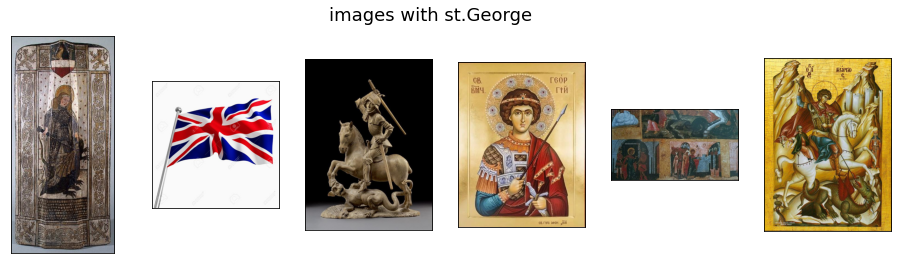

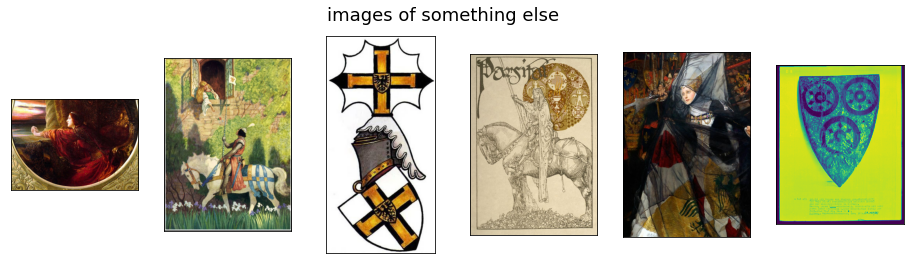

In [6]:
def show_imgs_from_list(img_list, nx=6, ny=1, suptitle='', shuffle=True):
    """Shows few random images from list of filenames
    Arguments:
    img_list -- list of files with images (proper path required)
    nx, ny -- number of images along X and Y axes
    suptitle -- Super title for plot
    """
    if len (img_list) < nx * ny:
        nx, ny = len (img_list), 1
    if shuffle:
        selected_imgs = np.random.choice(img_list, size=nx * ny, replace=False)
    else:
        selected_imgs = img_list
    
    fig, axs = plt.subplots(ny, nx, figsize=(4 + nx * 2, 1 + ny * 3))
    for ax, img_filename in zip(axs.ravel(), selected_imgs):
        img = Image.open(img_filename)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        ax.imshow(img)
    fig.suptitle(suptitle, fontsize=18)


show_imgs_from_list(files_list_g, suptitle='images with st.George')
show_imgs_from_list(files_list_ng, suptitle='images of something else')

## Prepare TF.Data datasets for training

In [7]:
"""combine filenames into single list"""
files_list = [*files_list_g, *files_list_ng]
np.random.shuffle(files_list)
split_point = int(len(files_list) * validation_split)

"""split list of Train / validation files names"""
train_files_list = files_list[split_point:]
val_files_list = files_list[:split_point]
len(train_files_list), len(val_files_list)

"""create datasets of Train / validation filenames"""

train_filenames_ds = tf.data.Dataset.list_files(train_files_list)
val_filenames_ds = tf.data.Dataset.list_files(val_files_list, shuffle=False)

In [8]:
"""Build dataset of images"""

def parse_image(filename:str, input_dim=(224,224,3)):
    """
    builds tf.data.Dataset with filenames; applied with `map`
    Performs simple conversions
    Arguments:
    filename -- filename string
    img_shape -- tuple of (img_height, img_width, channels) for output image
    channels -- num of color channels (typically 3 or 1)
    """
    parts = tf.strings.split(filename, os.sep)
    label = parts[-2]
    label = tf.cast(label == b'georges', tf.int32)  # set 0 or 1 label
    image = tf.io.read_file(filename)
    image = tf.io.decode_jpeg(image, channels=input_dim[-1])
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, input_dim[:2])
    return image, label


"""create datasets of Train / validation images"""
train_ds = train_filenames_ds.map(functools.partial(parse_image, input_dim=input_dim))
val_ds = val_filenames_ds.map(functools.partial(parse_image, input_dim=input_dim))

print(f"Created Train DS with {len(train_ds)} images; Val DS with {len(val_ds)} images")

"""Add batching and acceleration featues"""
train_ds = train_ds.cache().batch(train_batch_size). \
    shuffle(buffer_size=6000, seed=None, reshuffle_each_iteration=True). \
    prefetch(buffer_size=6000)
val_ds = val_ds.cache().batch(val_batch_size).prefetch(buffer_size=1000)

Created Train DS with 5130 images; Val DS with 570 images


In [9]:
""" Augment training dataset"""
augment_layers = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip(mode = "horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),
    tf.keras.layers.experimental.preprocessing.RandomZoom(
        height_factor=(-0.5, 0.5), width_factor=(-0.5, 0.5), fill_mode='reflect')
    ])

train_ds_aug = train_ds.map(lambda x, y: (augment_layers(x, training=True), y))

# Transfer learning model
Загружаем модель для Transfer learning

Используем **Xception** как показавшую хорошие результаты среди протестированных мной и авторами [статей](https://arxiv.org/pdf/1810.00736.pdf).

In [10]:
def build_model_for_transfer_learning(model_name: str, input_dim=(224, 224, 3)):
    """ downloads from Keras repo and prepares NN model for transfer learning
    Arguments:
    model_name -- name of model to be downloaded
    img_shape -- tuple of (img_height, img_width, channels) for model input 
    more models can be taken from here: https://keras.io/api/applications/
    """

    if model_name == 'EfficientNetB3':
        base_model = tf.keras.applications.EfficientNetB3(
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=input_dim,
            pooling=None,
            classes=2,
            classifier_activation="softmax",)

    elif model_name == 'EfficientNetB6':
        base_model = tf.keras.applications.EfficientNetB6(
            include_top=False,
            weights="imagenet",
            input_tensor=None,
            input_shape=input_dim,
            pooling=None,
            classes=2,
            classifier_activation="softmax",)
        
    elif model_name == 'Xception':
        base_model = keras.applications.Xception(
            weights='imagenet',
            input_shape=input_dim,
            include_top=False)
    else:
        print(f"Model with name '{model_name}' is not supported")
        return

    base_model.trainable = False
    return base_model


base_model = build_model_for_transfer_learning(model_name=model_name, input_dim=input_dim)

## first pass of transfer learning

In [11]:
"""building model using Keras functional API """
inputs = keras.Input(shape=input_dim)
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

""" PREPARE MODEL TO RUN: compile, set callback"""
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[keras.metrics.BinaryAccuracy()])

callbacks = [tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)]

In [12]:
history0 = model.fit(train_ds_aug, epochs=50, callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
214/214 [==============================] - 140s 464ms/step - loss: 0.5961 - binary_accuracy: 0.6349 - val_loss: 0.4730 - val_binary_accuracy: 0.7912
Epoch 2/50
214/214 [==============================] - 97s 448ms/step - loss: 0.4851 - binary_accuracy: 0.7464 - val_loss: 0.4459 - val_binary_accuracy: 0.8246
Epoch 3/50
214/214 [==============================] - 97s 450ms/step - loss: 0.4504 - binary_accuracy: 0.7784 - val_loss: 0.4074 - val_binary_accuracy: 0.8175
Epoch 4/50
214/214 [==============================] - 97s 449ms/step - loss: 0.4275 - binary_accuracy: 0.7906 - val_loss: 0.4000 - val_binary_accuracy: 0.8193
Epoch 5/50
214/214 [==============================] - 97s 450ms/step - loss: 0.4275 - binary_accuracy: 0.7980 - val_loss: 0.3879 - val_binary_accuracy: 0.8193
Epoch 6/50
214/214 [==============================] - 98s 452ms/step - loss: 0.4162 - binary_accuracy: 0.8030 - val_loss: 0.3793 - val_binary_accuracy: 0.8158
Epoch 7/50
214/214 [=========================

## fine-tuning the entire model

In [13]:
base_model.trainable = True  # allow learning
# model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],)

In [14]:
history1 = model.fit(train_ds_aug, epochs=50,
                     callbacks=callbacks, validation_data=val_ds)

Epoch 1/50
214/214 [==============================] - 233s 1s/step - loss: 0.3491 - binary_accuracy: 0.8469 - val_loss: 0.2936 - val_binary_accuracy: 0.8737
Epoch 2/50
214/214 [==============================] - 224s 1s/step - loss: 0.3025 - binary_accuracy: 0.8723 - val_loss: 0.2576 - val_binary_accuracy: 0.8877
Epoch 3/50
214/214 [==============================] - 222s 1s/step - loss: 0.2497 - binary_accuracy: 0.8923 - val_loss: 0.2630 - val_binary_accuracy: 0.9018
Epoch 4/50
214/214 [==============================] - 228s 1s/step - loss: 0.2339 - binary_accuracy: 0.9120 - val_loss: 0.2281 - val_binary_accuracy: 0.9000
Epoch 5/50
214/214 [==============================] - 226s 1s/step - loss: 0.1938 - binary_accuracy: 0.9194 - val_loss: 0.2445 - val_binary_accuracy: 0.9053
Epoch 6/50
214/214 [==============================] - 226s 1s/step - loss: 0.1870 - binary_accuracy: 0.9282 - val_loss: 0.2269 - val_binary_accuracy: 0.9193
Epoch 7/50
214/214 [==============================] - 226s

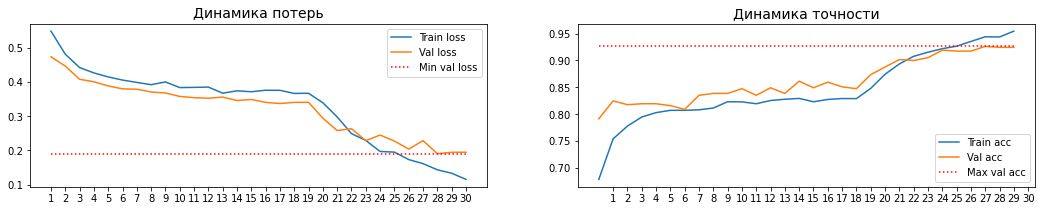

In [15]:
def plot_history(*args):
    """Plots loss and accuracy stats from multiple hisotry objects
    Arguments: history objects (need to have same metrics keys)
    note: adjust keys names in the code when changing metrics
    """
    histories = [arg for arg in args if type(
        arg) == tf.keras.callbacks.History]
    history = {'loss': [], 'binary_accuracy': [],
               'val_loss': [], 'val_binary_accuracy': []}
    for h in histories:
        for k in history.keys():
            history[k].extend(h.history[k])

    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 3))
    x = range(1, 1 + len(history['loss']))

    ax0.plot(x, history['loss'], label='Train loss')
    ax0.plot(x, history['val_loss'], label='Val loss')
    ax0.plot(x, [min(history['val_loss'])]*len(history['val_loss']),
             label='Min val loss', color='r', linestyle=':')
    ax0.set_title("Динамика потерь", fontsize=14)
    ax0.legend()
    ax0.set_xticks(range(1, 1 + len(history['loss'])))

    ax1.plot(history['binary_accuracy'], label='Train acc')
    ax1.plot(history['val_binary_accuracy'], label='Val acc')
    ax1.plot([max(history['val_binary_accuracy'])]*len(history['val_binary_accuracy']),
             label='Max val acc', color='r', linestyle=':')
    ax1.set_title("Динамика точности", fontsize=14)
    ax1.legend()
    ax1.set_xticks(range(1, 1 + len(history['loss'])))


plot_history(history0, history1)

# изучаем результаты классификации валидационной выборки

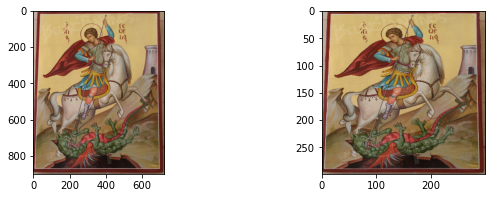

In [16]:
# test matching of validation file list and val dataset
# There should be 2 of the same images, original and rescaled

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,3))
for fn in val_filenames_ds:
    break
img = Image.open(fn.numpy())
ax0.imshow(img)

for bx, by in val_ds:
    break
ax1.imshow(bx[0]);

In [17]:
""" получаем результаты классификации валидационной выборки: """

# Список имён файлов получаем из датасета val_filenames_ds, чтобы иметь тот же порядок файлов, что и в val_ds
filenames = [f.numpy().decode('utf-8') for f in val_filenames_ds]

# obtain true and predicted labels from validation dataset + model
y_true, y_pred = [], []

for bx, by in tqdm(val_ds):
    by_pred = tf.cast(model(bx) > 0, tf.int8)
    y_pred.append(by_pred.numpy().flatten())
    y_true.append(by.numpy().flatten())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

  0%|          | 0/24 [00:00<?, ?it/s]

In [18]:
""" Измеряем точность: """

acc = keras.metrics.BinaryAccuracy()(y_true, y_pred).numpy()
print (f"достигнута точность {acc*100:.2f}%")

достигнута точность 92.63%


In [19]:
""" переносим данные о валидационной выборке в датафрейм"""

df = pd.DataFrame({'filename': filenames, 'y_true': y_true, 'y_pred': y_pred})
df['label'] = df.filename.apply(lambda x: x.split(os.sep)[-2][:-1])
df['correct'] = df.y_true == df.y_pred
df.sample(4)

,filename,y_true,y_pred,label,correct
164,c:\temp\project_georges\georges\b5ab7b8fd257f1...,1,1,george,True
378,c:\temp\project_georges\non_georges\6e5051f16b...,0,0,non_george,True
413,c:\temp\project_georges\non_georges\8769b7124c...,0,0,non_george,True
504,c:\temp\project_georges\non_georges\d6c8d656e8...,0,0,non_george,True


Detected 21 false negatives and 21 false positives


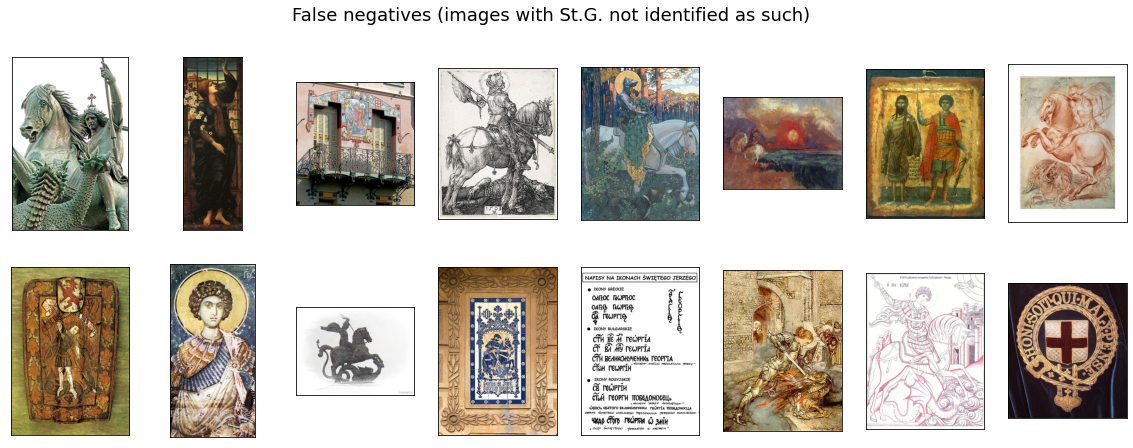

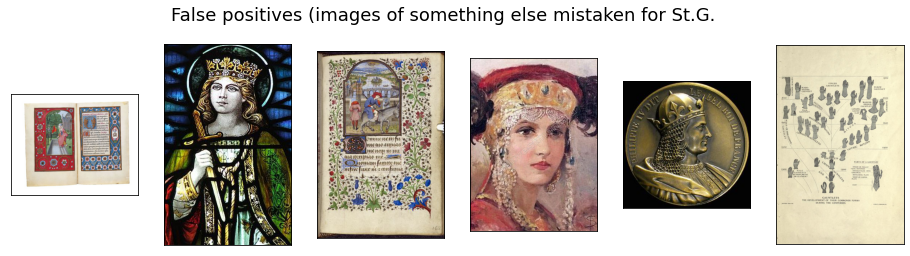

In [20]:
""" готовим списки ошибочно классифицированных файлов """

false_neg = df[(df.label == 'george') & (~df.correct)].filename.values
false_pos = df[(df.label == 'non_george') & (~df.correct)].filename.values
print(
    f"Detected {len(false_neg)} false negatives and {len(false_pos)} false positives")

""" выводим на экран примеры ошибочно классифицированных изображений """

show_imgs_from_list(false_neg, nx=8, ny=2, shuffle=False,
                    suptitle='False negatives (images with St.G. not identified as such)')
show_imgs_from_list(false_pos, nx=8, ny=2, shuffle=False,
                    suptitle='False positives (images of something else mistaken for St.G.')

## Выводы:

Построенная модель достигает точности распознавания изображений со св. Георгием на уровне 92%+